In [1]:
# This code is used for JHU CS 482/682: Deep Learning 2019 Spring Homework 4
# Copyright @ Johns Hopkins University, Cong Gao, cgao11@jhu.edu
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as functional
from torch.utils.data import DataLoader, Dataset
# from torchvision import transforms
import torchvision.transforms.functional as TF
from visdom import Visdom

from  PIL import Image
from datetime import datetime
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import random

import transforms
from dataset import MICCAIDataset

io.use_plugin('pil','imread')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda


## Function to show image

In [3]:
# helper function to show images
def imshow(inp, denormalize=False):
    """Imshow for batch of Tensor."""
    
    # Make a grid from batch
    inp = torchvision.utils.make_grid(inp)

    # convert and display
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    if denormalize:
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Visdom for real-time loss visualization

In [4]:
class Visualizations:
    def __init__(self, env_name=None):
        if env_name is None:
            env_name = str(datetime.now().strftime("%d-%m %Hh%M"))
        self.env_name = env_name
        self.vis = Visdom(env=self.env_name)
        self.loss_win = None
        self.seg_win = 0

    def plot_loss(self, loss, step):
        self.loss_win = self.vis.line(
            loss.reshape(1,2),
            np.array([step,step]).reshape(1,2),
            win=self.loss_win,
            update='append' if self.loss_win else None,
            opts=dict(
                xlabel='Epoch',
                ylabel='Loss',
                title='Loss (mean loss per 1 epoch)',
                legend=['training', 'validation']
            )
        )
        
    def plot_image(self, img, mask, pred):
        self.vis.image(
            img,
            win=self.seg_win,
            opts=dict(title='Sample Segmentation Input', caption='Input')
        )
        self.seg_win += 1
        self.vis.image(
            mask,
            win=self.seg_win,
            opts=dict(title='Sample Segmentation Mask', caption='Mask')
        )
        self.seg_win += 1
        self.vis.image(
            pred,
            win=self.seg_win,
            opts=dict(title='Sample Segmentation Pred', caption='Pred')
        )
        self.seg_win += 1
        
        
# # test functions
# vis = Visualizations('test')
# vis.plot_loss(np.array([0,1]),0)
# vis.plot_loss(np.array([2,3]),1)
# vis.plot_loss(np.array([4,5]),2)
# vis.plot_loss(np.array([1,3]),3)

# vis = Visualizations('test')
# img = sample['image']*0.5+0.5
# tmp_img = sample['image'].reshape(1,3,256,320)
# mask = sample['mask']
# pred = functional.softmax(model(tmp_img.cuda()), dim=1)
# pred_label = torch.max(pred,dim=1)[1]
# pred_label = pred_label.type(mask.type())
# vis.plot_image(img,class2mask(mask),class2mask(pred_label))

## Hyperparameters

In [5]:
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Q(a) and Q(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000

## Dataloader

Random Contrast


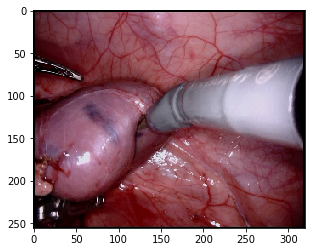

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


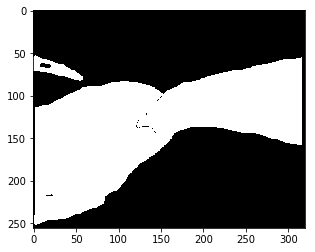

torch.Size([1, 256, 320])


In [21]:
train_dataset=MICCAIDataset(transform=transforms)


# show one example
img,label = train_dataset.__getitem__(0)
imshow(img,denormalize=True)
imshow(label)
print(label.shape)

In [493]:
# parse json file
num_class = 8
gray = [0,32,64,96,128,160,192,224]
label = [0,1,2,3,4,5,6,7]

# {
# 	"Background_Tissue": 0
# 	"Bipolar_Forceps": 32
# 	"Prograsp_Forceps": 64
# 	"Large_Needle_Driver": 96
# 	"Vessel_Sealer": 128
# 	"Grasping_Retractor": 160
# 	"Monopolar_Curved_Scissors": 192
# 	"Other": 224
# }

## Convert between gray level and mask

In [8]:
# helper function to convert the mask
def mask2class(mask):
    for index, (gray_value, label_value) in enumerate(zip(gray, label)):
        mask[mask==gray_value] = label_value
        
    return mask

def class2mask(class_label):
    mask = class_label.clone()
    for index, (gray_value, label_value) in enumerate(zip(gray, label)):
        mask[mask==label_value] = gray_value
        
    return mask

# # test functions
# normalize_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# train_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/train",list_transform=None,normalize=normalize_transform)

# sample = train_dataset.__getitem__(0)
# imshow(sample['image'],denormalize=True)
# mask = sample['mask']
# imshow(class2mask(mask))
# print(mask[0,100,150])

## Network

In [9]:
# define helper functions to add conv
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def add_merge_stage(ch_coarse, ch_fine, in_coarse, in_fine, upsample):
  conv = nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  torch.cat(conv, in_fine)

  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False)
  )
  upsample(in_coarse)

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )


In [10]:
# define unet model
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    ## weight initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

    ## Design your last layer & activations
    self.outconv = nn.Conv2d(32,num_class,1)
    
  def forward(self, x):
    conv1_out = self.conv1(x)
    conv2_out = self.conv2(self.max_pool(conv1_out))
    conv3_out = self.conv3(self.max_pool(conv2_out))
    conv4_out = self.conv4(self.max_pool(conv3_out))

    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out = self.conv3m(conv4m_out_)

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out = self.conv2m(conv3m_out_)

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out = self.conv1m(conv2m_out_)

    ## Design your last layer & activations
    outconv_out = self.outconv(conv1m_out)    
    
#     print('dimension of x', x.shape)
#     print('dimension of conv1_out', conv1_out.shape)
#     print('dimension of conv2_out', conv2_out.shape)
#     print('dimension of conv3_out', conv3_out.shape)

#     print('dimension of conv4_out', conv4_out.shape)
#     print('dimension of conv4m_out_', conv4m_out_.shape)

#     print('dimension of conv3m_out', conv3m_out.shape)
#     print('dimension of conv3m_out_', conv3m_out_.shape)

#     print('dimension of conv2m_out', conv2m_out.shape)
#     print('dimension of conv2m_out_', conv2m_out_.shape)

#     print('dimension of conv1m_out', conv1m_out.shape)
#     print('dimension of outconv_out', outconv_out.shape)

    return outconv_out

In [11]:
# initialize model
model = unet(useBN=True)
model.to(device)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

## Optimizer

In [12]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## Dice Loss

In [11]:
# define dice loss function
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    
    return (1 - dice_loss), probas, true_1_hot    

def label_accuracy(probas, true_1_hot):
    """Computes the accuracy.
    Args:
        probas: a tensor of shape [B, C, H, W] of probabilities
        true_1_hot: a tensor of shape [B, C, H, W]. Corresponds to the true label
    Returns:
        tp: [C] true positive of c classes
        fp: [C] false positive
        fn: [C] false negative
    """
    num_class = probas.shape[1]
    num_batch = probas.shape[0]
    
    pred = torch.max(probas,dim=1)[1]
    pred_1_hot = torch.eye(num_class)[pred.squeeze(1)]
    pred_1_hot = pred_1_hot.permute(0, 3, 1, 2).float()
    
    # sum all except class axis
    tp = torch.mul(pred_1_hot, true_1_hot).sum(dim=3).sum(dim=2).sum(dim=0)
    fp = pred_1_hot.sum(dim=3).sum(dim=2).sum(dim=0) - tp
    fn = true_1_hot.sum(dim=3).sum(dim=2).sum(dim=0) - tp
    
    return tp, fp, fn

# # test functions
# x = torch.tensor([[[0.1,0.2],[0.3,0.4]],[[0.2,0.3],[0.3,0.4]],[[0.3,0.4],[0.4,0.5]]]).reshape(1,3,2,2)
# print('x\n',x)
# gt = torch.tensor([[[1,2],[2,0]]])
# print('gt\n',gt)
# loss,probas,true_1_hot = dice_loss(x,gt.squeeze(1))
# print ('loss\n',loss)
# print('probability\n',probas)
# print('true_1_hot\n',true_1_hot)
# tp, fp,fn = label_accuracy(probas,true_1_hot)
# print('tp\n',tp)
# print('fp\n',fp)
# print('fn\n',fn)

## train and validation function

In [12]:
def train():
    ########################### Training #####################################
    # Please design your own training section
    scheduler.step()
    model.train()  # Set model to training mode           

    running_loss = 0.0
    
    for i_batch, sample_batch in enumerate(train_generator):
        # read in images and masks
        img = sample_batch['image']
        mask = sample_batch['mask']

#         # validate if images are parsed correctly
#         print(i_batch, img.size(), mask.size())
#         imshow(img,denormalize=True)
#         imshow(class2mask(mask))
#         # validate if data is being read correctly
#         print(img.shape)
#         print(img.shape)
#         print(torch.max(mask))

        # transfer to GPU
        img, mask = img.to(device), mask.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backprop + optimize
        outputs = model(img)
        loss,_,_ = dice_loss(outputs,mask.long().squeeze(1))
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * img.size(0)       
                
    train_loss = running_loss / len(train_dataset)
    print('Epoch Loss: {:.4f}'.format(train_loss))
    print('-' * 10)
    
    return train_loss
    
def validate():
    ########################### Validation #####################################
    model.eval()  # Set model to validation mode   
    validation_loss = 0.0
    tp = torch.zeros(num_class)
    fp = torch.zeros(num_class)
    fn = torch.zeros(num_class)
    
    for i_batch, sample_batch in enumerate(validation_generator):
        # read in images and masks
        img = sample_batch['image']
        mask = sample_batch['mask']
        
        # transfer to GPU
        img, mask = img.to(device), mask.to(device)

        # forward
        outputs = model(img)
        # get loss
        loss, probas, true_1_hot = dice_loss(outputs,mask.long().squeeze(1))

        # statistics
        validation_loss += loss.item() * img.size(0)        
        curr_tp, curr_fp, curr_fn = label_accuracy(probas.cpu(),true_1_hot.cpu())
        tp += curr_tp
        fp += curr_fp
        fn += curr_fn
            
    validation_loss = validation_loss / len(validation_dataset)
    print('Vaildation Loss: {:.4f}'.format(validation_loss))
    for i_class, (tp_val, fp_val, fn_val) in enumerate(zip(tp, fp, fn)):
        print ('{} Class, True Pos {}, False Pos {}, Flase Neg {}'.format(i_class, tp_val,fp_val,fn_val))
    print('-' * 10)
    
    return validation_loss

# Q1 (a) train a network without using any data augmentation

In [13]:
# define transform
train_transform = None
validation_transform = None

normalize_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.5,),(0.5,))])

In [14]:
# intialize the dataloader
train_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/train",list_transform=train_transform,normalize=normalize_transform)
validation_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/validation",list_transform=validation_transform,normalize=normalize_transform)

train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

In [17]:
print("Training Started!")

# Initialize the visualization environment
vis = Visualizations('Q1')

for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    # train
    train_loss = train()
    
    # validate
    with torch.no_grad():
        validation_loss = validate()
    
        # plot
        vis.plot_loss(np.array([train_loss,validation_loss]),epoch)
        # image
        sample = validation_dataset.__getitem__(random.randint(0,len(validation_dataset)-1))
        img = sample['image']*0.5+0.5
        tmp_img = sample['image'].reshape(1,3,256,320)
        mask = sample['mask']
        pred = functional.softmax(model(tmp_img.cuda()), dim=1)
        pred_label = torch.max(pred,dim=1)[1]
        pred_label = pred_label.type(mask.type())
        vis.plot_image(img,class2mask(mask),class2mask(pred_label))
    
    if epoch > 70:
        break

Training Started!

EPOCH 1 of 1000

Epoch Loss: 0.9236
----------
Vaildation Loss: 0.9212
0 Class, True Pos 2085591.0, False Pos 162452.0, Flase Neg 1363206.0
1 Class, True Pos 22454.0, False Pos 1621256.0, Flase Neg 30418.0
2 Class, True Pos 0.0, False Pos 0.0, Flase Neg 160200.0
3 Class, True Pos 72033.0, False Pos 34172.0, Flase Neg 191061.0
4 Class, True Pos 0.0, False Pos 0.0, Flase Neg 56550.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 0.0, Flase Neg 0.0
7 Class, True Pos 25895.0, False Pos 72147.0, Flase Neg 70877.0
----------

EPOCH 2 of 1000

Epoch Loss: 0.8844
----------
Vaildation Loss: 0.8661
0 Class, True Pos 1572591.0, False Pos 964.0, Flase Neg 1876206.0
1 Class, True Pos 2.0, False Pos 927233.0, Flase Neg 52870.0
2 Class, True Pos 56882.0, False Pos 432490.0, Flase Neg 103318.0
3 Class, True Pos 243028.0, False Pos 689045.0, Flase Neg 20066.0
4 Class, True Pos 0.0, False Pos 0.0, Flase Neg 56550.0
5 Class, True Pos 0.0, Fals

Vaildation Loss: 0.6117
0 Class, True Pos 3359882.0, False Pos 50536.0, Flase Neg 88915.0
1 Class, True Pos 21906.0, False Pos 64505.0, Flase Neg 30966.0
2 Class, True Pos 81337.0, False Pos 62774.0, Flase Neg 78863.0
3 Class, True Pos 226512.0, False Pos 77934.0, Flase Neg 36582.0
4 Class, True Pos 15555.0, False Pos 32495.0, Flase Neg 40995.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 11587.0, Flase Neg 0.0
7 Class, True Pos 72002.0, False Pos 18975.0, Flase Neg 24770.0
----------

EPOCH 16 of 1000

Epoch Loss: 0.5998
----------
Vaildation Loss: 0.5982
0 Class, True Pos 3381605.0, False Pos 62459.0, Flase Neg 67192.0
1 Class, True Pos 28243.0, False Pos 78320.0, Flase Neg 24629.0
2 Class, True Pos 82400.0, False Pos 52426.0, Flase Neg 77800.0
3 Class, True Pos 212122.0, False Pos 43647.0, Flase Neg 50972.0
4 Class, True Pos 18179.0, False Pos 39269.0, Flase Neg 38371.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True 

Epoch Loss: 0.5715
----------
Vaildation Loss: 0.5942
0 Class, True Pos 3380954.0, False Pos 59489.0, Flase Neg 67843.0
1 Class, True Pos 29873.0, False Pos 72896.0, Flase Neg 22999.0
2 Class, True Pos 92658.0, False Pos 57289.0, Flase Neg 67542.0
3 Class, True Pos 216476.0, False Pos 42450.0, Flase Neg 46618.0
4 Class, True Pos 15380.0, False Pos 30842.0, Flase Neg 41170.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 15095.0, Flase Neg 0.0
7 Class, True Pos 69555.0, False Pos 13043.0, Flase Neg 27217.0
----------

EPOCH 31 of 1000

Epoch Loss: 0.5655
----------
Vaildation Loss: 0.5865
0 Class, True Pos 3370623.0, False Pos 52112.0, Flase Neg 78174.0
1 Class, True Pos 30301.0, False Pos 74900.0, Flase Neg 22571.0
2 Class, True Pos 93160.0, False Pos 59560.0, Flase Neg 67040.0
3 Class, True Pos 221309.0, False Pos 49039.0, Flase Neg 41785.0
4 Class, True Pos 14438.0, False Pos 30089.0, Flase Neg 42112.0
5 Class, True Pos 0.0, False Pos 0.0, Fl

Epoch Loss: 0.5623
----------
Vaildation Loss: 0.5830
0 Class, True Pos 3379363.0, False Pos 57539.0, Flase Neg 69434.0
1 Class, True Pos 29648.0, False Pos 69930.0, Flase Neg 23224.0
2 Class, True Pos 92713.0, False Pos 56805.0, Flase Neg 67487.0
3 Class, True Pos 217648.0, False Pos 44867.0, Flase Neg 45446.0
4 Class, True Pos 15390.0, False Pos 29682.0, Flase Neg 41160.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 14202.0, Flase Neg 0.0
7 Class, True Pos 72471.0, False Pos 15742.0, Flase Neg 24301.0
----------

EPOCH 46 of 1000

Epoch Loss: 0.5747
----------
Vaildation Loss: 0.5913
0 Class, True Pos 3375205.0, False Pos 54911.0, Flase Neg 73592.0
1 Class, True Pos 28690.0, False Pos 69356.0, Flase Neg 24182.0
2 Class, True Pos 91560.0, False Pos 56957.0, Flase Neg 68640.0
3 Class, True Pos 222996.0, False Pos 53945.0, Flase Neg 40098.0
4 Class, True Pos 14715.0, False Pos 27657.0, Flase Neg 41835.0
5 Class, True Pos 0.0, False Pos 0.0, Fl

Epoch Loss: 0.5735
----------
Vaildation Loss: 0.5937
0 Class, True Pos 3377174.0, False Pos 56436.0, Flase Neg 71623.0
1 Class, True Pos 29607.0, False Pos 73480.0, Flase Neg 23265.0
2 Class, True Pos 92628.0, False Pos 57508.0, Flase Neg 67572.0
3 Class, True Pos 217092.0, False Pos 42228.0, Flase Neg 46002.0
4 Class, True Pos 15168.0, False Pos 29579.0, Flase Neg 41382.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 15160.0, Flase Neg 0.0
7 Class, True Pos 73255.0, False Pos 16685.0, Flase Neg 23517.0
----------

EPOCH 61 of 1000

Epoch Loss: 0.5740
----------
Vaildation Loss: 0.6034
0 Class, True Pos 3376095.0, False Pos 55723.0, Flase Neg 72702.0
1 Class, True Pos 29319.0, False Pos 70973.0, Flase Neg 23553.0
2 Class, True Pos 92678.0, False Pos 58008.0, Flase Neg 67522.0
3 Class, True Pos 219589.0, False Pos 47272.0, Flase Neg 43505.0
4 Class, True Pos 14727.0, False Pos 28182.0, Flase Neg 41823.0
5 Class, True Pos 0.0, False Pos 0.0, Fl

In [18]:
# save model
torch.save(model.state_dict(), 'vanilla_trained_unet.pt')

In [25]:
# load test dataset
test_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/test",list_transform=None,normalize=normalize_transform)
test_generator = DataLoader(test_dataset,shuffle=False,batch_size=4,num_workers=8)

In [23]:
def test():
    ########################### Test #####################################
    model.eval()  # Set model to validation mode   
    test_loss = 0.0
    tp = torch.zeros(num_class)
    fp = torch.zeros(num_class)
    fn = torch.zeros(num_class)
    
    for i_batch, sample_batch in enumerate(test_generator):
        # read in images and masks
        img = sample_batch['image']
        mask = sample_batch['mask']
        
        # transfer to GPU
        img, mask = img.to(device), mask.to(device)

        # forward
        outputs = model(img)
        # get loss
        loss, probas, true_1_hot = dice_loss(outputs,mask.long().squeeze(1))

        # statistics
        test_loss += loss.item() * img.size(0)        
        curr_tp, curr_fp, curr_fn = label_accuracy(probas.cpu(),true_1_hot.cpu())
        tp += curr_tp
        fp += curr_fp
        fn += curr_fn
        
        # visualize current prediction
        if i_batch == 3:
            imshow(img.cpu(),denormalize=True)
            imshow(class2mask(mask).cpu())
            pred = functional.softmax(outputs, dim=1)
            pred_label = torch.max(pred,dim=1)[1]
            pred_mask = class2mask(pred_label)
            pred_mask = torch.reshape(pred_mask,(pred_mask.shape[0],1,pred_mask.shape[1],pred_mask.shape[2]))
            imshow(pred_mask.cpu())
            
    dice = (2*tp + 1e-7)/ (2*tp+fp+fn+1e-7)
    dice = dice.mean()
    print('Dice Score: {:.4f}'.format(dice.item()))
    for i_class, (tp_val, fp_val, fn_val) in enumerate(zip(tp, fp, fn)):
        print ('{} Class, True Pos {}, False Pos {}, Flase Neg {}'.format(i_class, tp_val,fp_val,fn_val))
    print('-' * 10)
    
    return dice

In [18]:
model = unet(useBN=True)
model.load_state_dict(torch.load('vanilla_trained_unet.pt'))
model.to(device)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

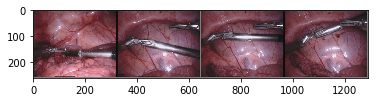

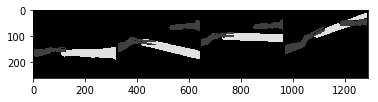

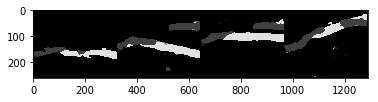

Dice Score: 0.6330
0 Class, True Pos 3395835.0, False Pos 43879.0, Flase Neg 80960.0
1 Class, True Pos 34156.0, False Pos 43667.0, Flase Neg 31664.0
2 Class, True Pos 131399.0, False Pos 62016.0, Flase Neg 53017.0
3 Class, True Pos 181589.0, False Pos 38948.0, Flase Neg 46696.0
4 Class, True Pos 5558.0, False Pos 20723.0, Flase Neg 8350.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 0.0
6 Class, True Pos 0.0, False Pos 8066.0, Flase Neg 0.0
7 Class, True Pos 105966.0, False Pos 24198.0, Flase Neg 20810.0
----------


In [27]:
dice = test()

## Q1 b, Data Augmentation

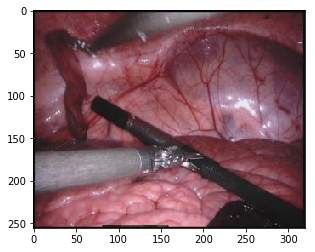

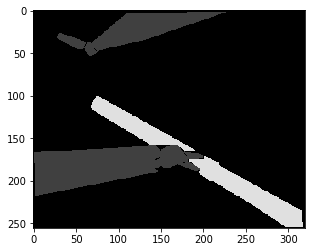

torch.Size([1, 256, 320])


In [28]:
train_transform = [
    transforms.RandomRotation(degrees=90,resample=False),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomResizedCrop((256,320))
]
normalize_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.5,),(0.5,))])
train_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/train",list_transform=train_transform,
                           normalize=normalize_transform)

# show one example
sample = train_dataset.__getitem__(20)
imshow(sample['image'],denormalize=True)
mask = sample['mask']
imshow(class2mask(mask))
print(mask.shape)

In [29]:
# build data generator
train_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/train",list_transform=train_transform,
                           normalize=normalize_transform)
validation_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/validation",list_transform=None,normalize=normalize_transform)

train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

In [25]:
model = unet(useBN=True)
model.load_state_dict(torch.load('vanilla_trained_unet.pt'))
model.to(device)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

In [26]:
# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [28]:
print("Training Started!")

# Initialize the visualization environment
vis = Visualizations('Q1_b')

for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    # test
    test_loss = train()
    
    # validate
    with torch.no_grad():
        validation_loss = validate()
    
        # plot
        vis.plot_loss(np.array([test_loss,validation_loss]),epoch)
        # image
        sample = validation_dataset.__getitem__(random.randint(0,len(validation_dataset)-1))
        img = sample['image']*0.5+0.5
        tmp_img = sample['image'].reshape(1,3,256,320)
        mask = sample['mask']
        pred = functional.softmax(model(tmp_img.cuda()), dim=1)
        pred_label = torch.max(pred,dim=1)[1]
        pred_label = pred_label.type(mask.type())
        vis.plot_image(img,class2mask(mask),class2mask(pred_label))
    
    
    if epoch > 70:
        break

Training Started!

EPOCH 1 of 1000

Epoch Loss: 0.6429
----------
Vaildation Loss: 0.6192
0 Class, True Pos 3350363.0, False Pos 50546.0, Flase Neg 98434.0
1 Class, True Pos 13837.0, False Pos 21640.0, Flase Neg 39035.0
2 Class, True Pos 79833.0, False Pos 73249.0, Flase Neg 80367.0
3 Class, True Pos 233730.0, False Pos 111925.0, Flase Neg 29364.0
4 Class, True Pos 13575.0, False Pos 21458.0, Flase Neg 42975.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 4963.0, Flase Neg 0.0
7 Class, True Pos 79075.0, False Pos 41806.0, Flase Neg 17697.0
----------

EPOCH 2 of 1000

Epoch Loss: 0.6454
----------
Vaildation Loss: 0.6666
0 Class, True Pos 3361778.0, False Pos 52725.0, Flase Neg 87019.0
1 Class, True Pos 25636.0, False Pos 114633.0, Flase Neg 27236.0
2 Class, True Pos 48372.0, False Pos 52724.0, Flase Neg 111828.0
3 Class, True Pos 105980.0, False Pos 18775.0, Flase Neg 157114.0
4 Class, True Pos 7485.0, False Pos 22420.0, Flase Neg 49065.0
5 C

Epoch Loss: 0.5947
----------
Vaildation Loss: 0.5847
0 Class, True Pos 3380910.0, False Pos 51736.0, Flase Neg 67887.0
1 Class, True Pos 29317.0, False Pos 46283.0, Flase Neg 23555.0
2 Class, True Pos 91344.0, False Pos 55120.0, Flase Neg 68856.0
3 Class, True Pos 219830.0, False Pos 65651.0, Flase Neg 43264.0
4 Class, True Pos 15490.0, False Pos 27304.0, Flase Neg 41060.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 21654.0, Flase Neg 0.0
7 Class, True Pos 75322.0, False Pos 16039.0, Flase Neg 21450.0
----------

EPOCH 16 of 1000

Epoch Loss: 0.5912
----------
Vaildation Loss: 0.5605
0 Class, True Pos 3379108.0, False Pos 48974.0, Flase Neg 69689.0
1 Class, True Pos 29323.0, False Pos 41151.0, Flase Neg 23549.0
2 Class, True Pos 96970.0, False Pos 51968.0, Flase Neg 63230.0
3 Class, True Pos 226930.0, False Pos 65002.0, Flase Neg 36164.0
4 Class, True Pos 14710.0, False Pos 23436.0, Flase Neg 41840.0
5 Class, True Pos 0.0, False Pos 0.0, Fl

Vaildation Loss: 0.5670
0 Class, True Pos 3371955.0, False Pos 44426.0, Flase Neg 76842.0
1 Class, True Pos 32354.0, False Pos 41356.0, Flase Neg 20518.0
2 Class, True Pos 106136.0, False Pos 61435.0, Flase Neg 54064.0
3 Class, True Pos 225591.0, False Pos 52985.0, Flase Neg 37503.0
4 Class, True Pos 17194.0, False Pos 28273.0, Flase Neg 39356.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 16483.0, Flase Neg 0.0
7 Class, True Pos 78221.0, False Pos 19591.0, Flase Neg 18551.0
----------

EPOCH 30 of 1000

Epoch Loss: 0.5819
----------
Vaildation Loss: 0.5758
0 Class, True Pos 3367753.0, False Pos 42928.0, Flase Neg 81044.0
1 Class, True Pos 32455.0, False Pos 44617.0, Flase Neg 20417.0
2 Class, True Pos 104403.0, False Pos 58837.0, Flase Neg 55797.0
3 Class, True Pos 226677.0, False Pos 53759.0, Flase Neg 36417.0
4 Class, True Pos 16734.0, False Pos 28994.0, Flase Neg 39816.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, Tru

Epoch Loss: 0.5855
----------
Vaildation Loss: 0.5585
0 Class, True Pos 3359485.0, False Pos 37387.0, Flase Neg 89312.0
1 Class, True Pos 32154.0, False Pos 40793.0, Flase Neg 20718.0
2 Class, True Pos 105553.0, False Pos 63394.0, Flase Neg 54647.0
3 Class, True Pos 229620.0, False Pos 60863.0, Flase Neg 33474.0
4 Class, True Pos 15898.0, False Pos 26299.0, Flase Neg 40652.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 18425.0, Flase Neg 0.0
7 Class, True Pos 80987.0, False Pos 25142.0, Flase Neg 15785.0
----------

EPOCH 45 of 1000

Epoch Loss: 0.5875
----------
Vaildation Loss: 0.5833
0 Class, True Pos 3368499.0, False Pos 42222.0, Flase Neg 80298.0
1 Class, True Pos 31671.0, False Pos 39985.0, Flase Neg 21201.0
2 Class, True Pos 104678.0, False Pos 57613.0, Flase Neg 55522.0
3 Class, True Pos 227921.0, False Pos 57329.0, Flase Neg 35173.0
4 Class, True Pos 16663.0, False Pos 27124.0, Flase Neg 39887.0
5 Class, True Pos 0.0, False Pos 0.0, 

Vaildation Loss: 0.5631
0 Class, True Pos 3372995.0, False Pos 45716.0, Flase Neg 75802.0
1 Class, True Pos 32924.0, False Pos 44740.0, Flase Neg 19948.0
2 Class, True Pos 104964.0, False Pos 58974.0, Flase Neg 55236.0
3 Class, True Pos 223242.0, False Pos 46770.0, Flase Neg 39852.0
4 Class, True Pos 17249.0, False Pos 30436.0, Flase Neg 39301.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 18930.0, Flase Neg 0.0
7 Class, True Pos 78985.0, False Pos 20075.0, Flase Neg 17787.0
----------

EPOCH 59 of 1000

Epoch Loss: 0.5754
----------
Vaildation Loss: 0.5643
0 Class, True Pos 3370136.0, False Pos 43623.0, Flase Neg 78661.0
1 Class, True Pos 32727.0, False Pos 44267.0, Flase Neg 20145.0
2 Class, True Pos 104309.0, False Pos 56407.0, Flase Neg 55891.0
3 Class, True Pos 225085.0, False Pos 54187.0, Flase Neg 38009.0
4 Class, True Pos 16653.0, False Pos 26922.0, Flase Neg 39897.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, Tru

In [29]:
# save model
torch.save(model.state_dict(), 'aug_trained_unet.pt')

In [30]:
model = unet(useBN=True)
model.load_state_dict(torch.load('aug_trained_unet.pt'))
model.to(device)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

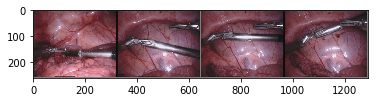

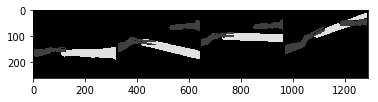

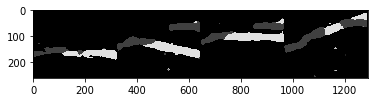

Dice Score: 0.6304
0 Class, True Pos 3396024.0, False Pos 38719.0, Flase Neg 80771.0
1 Class, True Pos 25698.0, False Pos 23854.0, Flase Neg 40122.0
2 Class, True Pos 139468.0, False Pos 82822.0, Flase Neg 44948.0
3 Class, True Pos 184812.0, False Pos 44907.0, Flase Neg 43473.0
4 Class, True Pos 4888.0, False Pos 15380.0, Flase Neg 9020.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 0.0
6 Class, True Pos 0.0, False Pos 8661.0, Flase Neg 0.0
7 Class, True Pos 107696.0, False Pos 23071.0, Flase Neg 19080.0
----------


tensor(0.6304)

In [31]:
dice = test()

In [35]:
# check learned parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

conv1.0.weight tensor([[[[-1.4060e-01, -8.6469e-02,  7.4225e-02],
          [-5.2846e-02, -8.9088e-02,  5.2405e-02],
          [-1.7597e-01, -2.6559e-02, -1.5421e-01]],

         [[ 1.5420e-01, -1.4118e-01,  7.0249e-02],
          [ 1.3022e-01,  1.7824e-01,  5.4708e-02],
          [-1.8331e-02, -1.3052e-01,  1.9826e-01]],

         [[ 1.8637e-02, -1.3416e-02, -1.8697e-01],
          [-1.9344e-01,  8.3889e-02,  6.3303e-02],
          [ 1.1384e-01,  1.7255e-01, -2.7587e-02]]],


        [[[-1.0249e-01,  1.5164e-01, -4.8729e-02],
          [-1.8001e-02,  1.6856e-01,  1.8278e-01],
          [ 1.7471e-01,  7.4781e-02,  3.1318e-02]],

         [[-2.7481e-02,  1.3771e-01,  3.5854e-02],
          [-1.7143e-01, -1.7508e-01,  7.9905e-02],
          [-9.5017e-03, -2.1083e-02, -1.7919e-01]],

         [[-7.8156e-02, -6.5313e-03, -1.2733e-01],
          [ 9.9780e-02,  9.9142e-02, -1.0422e-01],
          [-1.5242e-01,  1.5046e-01,  1.0588e-01]]],


        [[[-1.6588e-01, -1.4793e-01, -4.5973e-02],


conv2.3.weight tensor([[[[ 2.6418e-02, -2.6834e-03,  4.2271e-02],
          [-2.4614e-02,  1.7149e-02, -1.2675e-02],
          [-1.8312e-03, -5.4086e-03, -3.8546e-02]],

         [[ 7.7217e-02,  6.6887e-02,  4.9694e-02],
          [ 1.0878e-01,  1.0953e-01,  1.0985e-01],
          [ 3.6957e-02, -2.8757e-02,  7.8897e-03]],

         [[-6.8661e-03,  3.9280e-02,  4.2469e-02],
          [ 1.2380e-02,  1.5906e-02,  2.7104e-02],
          [-5.5063e-02, -2.6684e-02, -8.3538e-03]],

         ...,

         [[-1.7999e-02, -2.0163e-02,  1.6754e-02],
          [-1.4259e-02, -3.3922e-02,  2.1975e-02],
          [ 5.6797e-02,  7.3760e-03, -1.6591e-02]],

         [[ 1.7846e-02, -2.0605e-02, -2.8639e-02],
          [-1.9478e-02, -4.1503e-02, -2.3269e-02],
          [-5.8974e-02, -7.8805e-02, -1.1120e-01]],

         [[-2.0199e-02, -3.9226e-02, -2.7118e-02],
          [-5.3047e-02, -2.7793e-02, -3.1270e-02],
          [-4.4286e-02, -1.6573e-02, -8.7802e-02]]],


        [[[-4.3375e-02, -2.5366e-02, -

conv3m.0.weight tensor([[[[-4.5470e-02, -3.3935e-02, -1.6914e-02],
          [-2.8121e-03, -2.9953e-02, -1.9400e-02],
          [-1.4226e-02, -6.9493e-03, -1.7548e-02]],

         [[-9.4713e-03,  7.2416e-02,  1.5575e-01],
          [-3.1609e-03,  4.7647e-02,  1.6822e-01],
          [ 1.8652e-02,  5.4771e-02,  1.2105e-01]],

         [[-2.2543e-02,  2.1381e-02,  5.5758e-04],
          [-3.1526e-02, -1.9634e-02, -2.0222e-02],
          [-1.9148e-02, -2.2576e-03,  4.9979e-04]],

         ...,

         [[-6.8101e-03, -2.1291e-02, -2.1275e-03],
          [-9.3247e-03,  9.3032e-03, -3.3907e-03],
          [-4.3739e-03, -2.1121e-02, -3.3274e-02]],

         [[ 4.5040e-04,  5.3471e-03, -2.6799e-02],
          [-7.3299e-03, -2.9113e-02, -3.3344e-02],
          [-2.9645e-02,  9.9268e-04, -1.1174e-02]],

         [[ 1.6502e-02, -8.2309e-03,  1.5862e-02],
          [ 2.3141e-02,  2.3441e-02,  1.2665e-02],
          [-1.9529e-03, -2.4620e-02, -5.9240e-03]]],


        [[[-1.2267e-02, -2.1748e-02, 

upsample43.0.weight tensor([[[[ 1.3830e-02, -1.6929e-02, -6.3114e-03, -1.2006e-02],
          [-6.8157e-05, -5.3270e-03,  1.4866e-02,  1.3406e-02],
          [-1.5300e-02,  1.2874e-02,  8.9597e-03,  9.7390e-03],
          [-1.2522e-02,  1.8378e-02, -1.1374e-02,  3.2956e-03]],

         [[ 7.4898e-02,  5.2964e-02, -2.7087e-03,  2.9019e-02],
          [ 2.1878e-02, -2.5429e-02, -1.5585e-02, -1.9167e-02],
          [ 1.3111e-02, -2.8549e-02, -5.1934e-02, -8.0152e-02],
          [ 1.7704e-02, -3.0515e-02, -6.2070e-02,  5.5052e-03]],

         [[-5.6516e-03, -1.7153e-02, -1.4191e-02, -4.1284e-02],
          [-2.3082e-02, -8.0448e-03,  2.3563e-02, -2.8669e-04],
          [ 5.7122e-03, -1.1694e-02,  4.9830e-02,  1.7016e-02],
          [-5.6145e-03,  7.6017e-03,  3.6025e-02,  5.4085e-03]],

         ...,

         [[ 1.3129e-02, -2.3292e-02,  2.6850e-02, -3.9466e-02],
          [-1.5933e-02, -9.8221e-03, -1.8987e-02, -3.0123e-02],
          [ 5.3599e-02, -2.1880e-02,  3.6669e-02, -1.0479e-02],

## Q1 c, Tweak hyperparameters

In [27]:
# increase training batch size
train_batch_size=15
validation_batch_size=15
# decrease learning rate
learning_rate = 0.0001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000

In [28]:
# build data generator
train_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/train",list_transform=train_transform,
                           normalize=normalize_transform)
validation_dataset=ImageDataset(input_dir = "Hw6_Q1_dataset/HW6_data/segmentation/validation",list_transform=None,normalize=normalize_transform)

train_generator = DataLoader(train_dataset,shuffle=True,batch_size=train_batch_size,num_workers=8)
validation_generator = DataLoader(validation_dataset,shuffle=True,batch_size=validation_batch_size,num_workers=8)

In [19]:
model = unet(useBN=True)
model.load_state_dict(torch.load('tweaked_trained_unet_weight_decay.pt'))
model.to(device)

# intialize optimizer and lr decay
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [29]:
print("Training Started!")

# Initialize the visualization environment
vis = Visualizations('Q1_c')

for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    
    # test
    test_loss = train()
    
    # validate
    with torch.no_grad():
        validation_loss = validate()
    
        # plot
        vis.plot_loss(np.array([test_loss,validation_loss]),epoch)
        # image
        sample = validation_dataset.__getitem__(random.randint(0,len(validation_dataset)-1))        
        img = sample['image']*0.5+0.5
        tmp_img = sample['image'].reshape(1,3,256,320)
        mask = sample['mask']
        pred = functional.softmax(model(tmp_img.cuda()), dim=1)
        pred_label = torch.max(pred,dim=1)[1]
        pred_label = pred_label.type(mask.type())
        vis.plot_image(img,class2mask(mask),class2mask(pred_label))

    
    
    if epoch > 70:
        break

Training Started!

EPOCH 1 of 1000

Epoch Loss: 0.5184
----------
Vaildation Loss: 0.5702
0 Class, True Pos 3388562.0, False Pos 53898.0, Flase Neg 60235.0
1 Class, True Pos 33024.0, False Pos 43029.0, Flase Neg 19848.0
2 Class, True Pos 106426.0, False Pos 40708.0, Flase Neg 53774.0
3 Class, True Pos 230778.0, False Pos 38675.0, Flase Neg 32316.0
4 Class, True Pos 22949.0, False Pos 34946.0, Flase Neg 33601.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 15188.0, Flase Neg 0.0
7 Class, True Pos 74770.0, False Pos 13047.0, Flase Neg 22002.0
----------

EPOCH 2 of 1000

Epoch Loss: 0.5112
----------
Vaildation Loss: 0.5502
0 Class, True Pos 3386755.0, False Pos 51634.0, Flase Neg 62042.0
1 Class, True Pos 33557.0, False Pos 43399.0, Flase Neg 19315.0
2 Class, True Pos 108408.0, False Pos 44600.0, Flase Neg 51792.0
3 Class, True Pos 227238.0, False Pos 32923.0, Flase Neg 35856.0
4 Class, True Pos 23166.0, False Pos 36433.0, Flase Neg 33384.0
5 C

Epoch Loss: 0.5054
----------
Vaildation Loss: 0.5400
0 Class, True Pos 3389680.0, False Pos 54520.0, Flase Neg 59117.0
1 Class, True Pos 32434.0, False Pos 39455.0, Flase Neg 20438.0
2 Class, True Pos 107787.0, False Pos 43246.0, Flase Neg 52413.0
3 Class, True Pos 229825.0, False Pos 36358.0, Flase Neg 33269.0
4 Class, True Pos 23184.0, False Pos 35340.0, Flase Neg 33366.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 15061.0, Flase Neg 0.0
7 Class, True Pos 75469.0, False Pos 13641.0, Flase Neg 21303.0
----------

EPOCH 16 of 1000

Epoch Loss: 0.4997
----------
Vaildation Loss: 0.5545
0 Class, True Pos 3390666.0, False Pos 55116.0, Flase Neg 58131.0
1 Class, True Pos 33024.0, False Pos 41159.0, Flase Neg 19848.0
2 Class, True Pos 108087.0, False Pos 43591.0, Flase Neg 52113.0
3 Class, True Pos 227130.0, False Pos 32423.0, Flase Neg 35964.0
4 Class, True Pos 23680.0, False Pos 36190.0, Flase Neg 32870.0
5 Class, True Pos 0.0, False Pos 0.0, 

Vaildation Loss: 0.5359
0 Class, True Pos 3391201.0, False Pos 55895.0, Flase Neg 57596.0
1 Class, True Pos 33071.0, False Pos 41474.0, Flase Neg 19801.0
2 Class, True Pos 107857.0, False Pos 43737.0, Flase Neg 52343.0
3 Class, True Pos 225893.0, False Pos 31413.0, Flase Neg 37201.0
4 Class, True Pos 23596.0, False Pos 36938.0, Flase Neg 32954.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 15663.0, Flase Neg 0.0
7 Class, True Pos 75545.0, False Pos 13717.0, Flase Neg 21227.0
----------

EPOCH 30 of 1000

Epoch Loss: 0.5034
----------
Vaildation Loss: 0.5484
0 Class, True Pos 3389617.0, False Pos 54279.0, Flase Neg 59180.0
1 Class, True Pos 33256.0, False Pos 42345.0, Flase Neg 19616.0
2 Class, True Pos 107427.0, False Pos 42326.0, Flase Neg 52773.0
3 Class, True Pos 227846.0, False Pos 33517.0, Flase Neg 35248.0
4 Class, True Pos 23480.0, False Pos 35979.0, Flase Neg 33070.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, Tru


EPOCH 44 of 1000

Epoch Loss: 0.5079
----------
Vaildation Loss: 0.5518
0 Class, True Pos 3390255.0, False Pos 55244.0, Flase Neg 58542.0
1 Class, True Pos 33662.0, False Pos 44406.0, Flase Neg 19210.0
2 Class, True Pos 106653.0, False Pos 40724.0, Flase Neg 53547.0
3 Class, True Pos 227412.0, False Pos 33225.0, Flase Neg 35682.0
4 Class, True Pos 23739.0, False Pos 36678.0, Flase Neg 32811.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 15798.0, Flase Neg 0.0
7 Class, True Pos 74941.0, False Pos 13263.0, Flase Neg 21831.0
----------

EPOCH 45 of 1000

Epoch Loss: 0.5083
----------
Vaildation Loss: 0.5502
0 Class, True Pos 3385194.0, False Pos 50426.0, Flase Neg 63603.0
1 Class, True Pos 32792.0, False Pos 40423.0, Flase Neg 20080.0
2 Class, True Pos 107973.0, False Pos 43889.0, Flase Neg 52227.0
3 Class, True Pos 230714.0, False Pos 36283.0, Flase Neg 32380.0
4 Class, True Pos 23282.0, False Pos 36349.0, Flase Neg 33268.0
5 Class, True Pos 0

Epoch Loss: 0.5104
----------
Vaildation Loss: 0.5464
0 Class, True Pos 3387306.0, False Pos 52131.0, Flase Neg 61491.0
1 Class, True Pos 33549.0, False Pos 43727.0, Flase Neg 19323.0
2 Class, True Pos 106999.0, False Pos 41837.0, Flase Neg 53201.0
3 Class, True Pos 228403.0, False Pos 33618.0, Flase Neg 34691.0
4 Class, True Pos 23450.0, False Pos 36892.0, Flase Neg 33100.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 16068.0, Flase Neg 0.0
7 Class, True Pos 76965.0, False Pos 15055.0, Flase Neg 19807.0
----------

EPOCH 59 of 1000

Epoch Loss: 0.5068
----------
Vaildation Loss: 0.5337
0 Class, True Pos 3391710.0, False Pos 56150.0, Flase Neg 57087.0
1 Class, True Pos 32970.0, False Pos 41169.0, Flase Neg 19902.0
2 Class, True Pos 107659.0, False Pos 42497.0, Flase Neg 52541.0
3 Class, True Pos 227092.0, False Pos 32230.0, Flase Neg 36002.0
4 Class, True Pos 23948.0, False Pos 36926.0, Flase Neg 32602.0
5 Class, True Pos 0.0, False Pos 0.0, 

Vaildation Loss: 0.5372
0 Class, True Pos 3389948.0, False Pos 54595.0, Flase Neg 58849.0
1 Class, True Pos 33383.0, False Pos 43086.0, Flase Neg 19489.0
2 Class, True Pos 107477.0, False Pos 42653.0, Flase Neg 52723.0
3 Class, True Pos 227397.0, False Pos 33928.0, Flase Neg 35697.0
4 Class, True Pos 22879.0, False Pos 34837.0, Flase Neg 33671.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 17715.0
6 Class, True Pos 0.0, False Pos 15281.0, Flase Neg 0.0
7 Class, True Pos 76172.0, False Pos 14364.0, Flase Neg 20600.0
----------


In [31]:
# save model
torch.save(model.state_dict(), 'tweaked_trained_unet_weight_decay.pt')

In [32]:
model = unet(useBN=True)
model.load_state_dict(torch.load('tweaked_trained_unet_weight_decay.pt'))
model.to(device)

unet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=

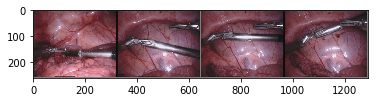

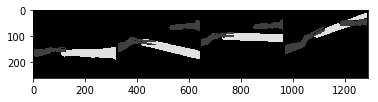

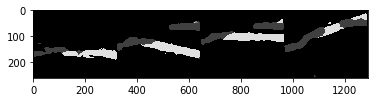

Dice Score: 0.6609
0 Class, True Pos 3416634.0, False Pos 47925.0, Flase Neg 60161.0
1 Class, True Pos 32597.0, False Pos 23870.0, Flase Neg 33223.0
2 Class, True Pos 139785.0, False Pos 53786.0, Flase Neg 44631.0
3 Class, True Pos 186958.0, False Pos 34272.0, Flase Neg 41327.0
4 Class, True Pos 7573.0, False Pos 21445.0, Flase Neg 6335.0
5 Class, True Pos 0.0, False Pos 0.0, Flase Neg 0.0
6 Class, True Pos 0.0, False Pos 5721.0, Flase Neg 0.0
7 Class, True Pos 106612.0, False Pos 18822.0, Flase Neg 20164.0
----------


tensor(0.6609)

In [30]:
test()